# Micrograd Code, by Ali Jazbi

In [1]:
# here is a mathematical expression that takes 3 inputs and produces one output
from math import sin, cos

def f(a, b, c):
  return -a**3 + sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

6.336362190988558


In [2]:
# write the function df that returns the analytical gradient of f
# i.e. use your skills from calculus to take the derivative, then implement the formula

def gradf(a, b, c):
  return [3*-a**2 - 0.5*(1/a**0.5), 3*cos(3*b) + 2.5*b**1.5, 1/c**2] # todo, return [df/da, df/db, df/dc]


# expected answer is the list of 
ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)
for dim in range(3):
  ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625


In [3]:
# now estimate the gradient numerically without any calculus, using
# the approximation we used in the video.
# you should not call the function df from the last cell

# -----------
a = 2
b = 3
c = 4

delta_a = -3 * a**2 - 0.5 * a ** (-0.5)
delta_b = 3 * cos(3*b) + 2.5 * b**1.5
delta_c = c ** (-2)

numerical_grad = [delta_a, delta_b, delta_c] # TODO
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625


In [4]:
# there is an alternative formula that provides a much better numerical 
# approximation to the derivative of a function.
# learn about it here: https://en.wikipedia.org/wiki/Symmetric_derivative
# implement it. confirm that for the same step size h this version gives a
# better approximation.

# -----------
h = 0.0000001
numerical_grad2 = [(f(2+h,3,4)-f(2-h,3,4))/(2*h), (f(2,3+h,4)-f(2,3-h,4))/(2*h), (f(2,3,4+h)-f(2,3,4-h))/(2*h)] # TODO# -----------
# -----------


for dim in range(3):
  ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553380251014
OK for dim 1: expected 10.25699027111255, yours returns 10.256990252699438
OK for dim 2: expected 0.0625, yours returns 0.06250000073038109


# section 2: support for softmax

In [5]:
# Value class starter code, with many functions taken out
from math import exp, log
import numpy as np
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other) :
     #print(self.data,'self')
     #print(other.data,'other')
     other = other if isinstance(other, Value) else Value(other)
     out = Value(self.data * other.data, (self, other), '*')

     def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
     out._backward = _backward
     return out


  def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

  def log(self):
    out = Value(log(self.data), (self,), 'log')

    def _backward():
      self.grad += (1/self.data) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    other = Value(other) if not isinstance(other, Value) else other
    return self * other**-1

  def __rtruediv__(self, other): # other / self
    return other * self**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other


  def __rmul__(self,other):
    return self * other

  def exp(self):
    x = self.data
    out = Value(exp(x), (self,) , 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (exp(2*x) - 1)/(exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out


  def backward(self): # exactly as in video

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [6]:
# Install the Graphviz Python package:
# https://graphviz.org/download/   graphviz-11.0.0 (32-bit) EXE installer
#!pip install graphviz


In [7]:
#Testing graphvis
import os
from graphviz import ExecutableNotFound

# Define the path to the Graphviz executable
graphviz_path = 'C:/Program Files (x86)/Graphviz/bin'  # installed location

# Add the Graphviz bin directory to the system PATH
os.environ["PATH"] += os.pathsep + graphviz_path

# Now you can use Graphviz in your code
import graphviz

# Example code to create a simple graph
dot = graphviz.Digraph(comment='Test Graph')
dot.node('A', 'Node A')
dot.node('B', 'Node B')
dot.edge('A', 'B')

# Render and view the graph
dot.render('test-output/test-graph', format='png', view=True)

'test-output\\test-graph.png'

In [8]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir, }) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
     

# Testing ans examples
# Testing with first example

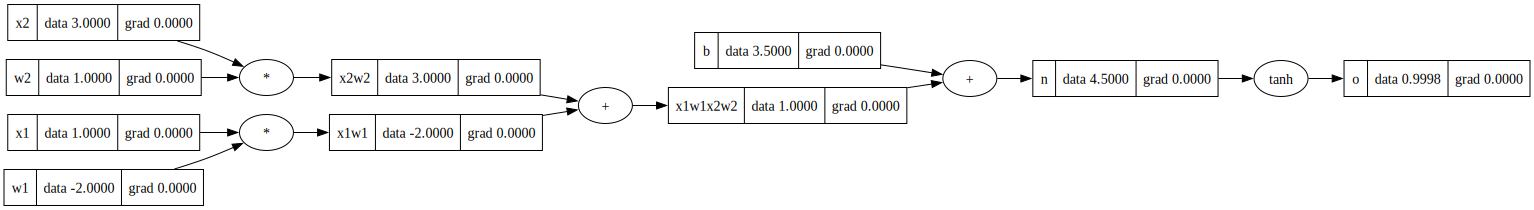

In [9]:
x1 = Value(1.0, label='x1')
x2 = Value(3.0, label='x2')
w1 = Value(-2.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(3.5, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [10]:
o.backward()

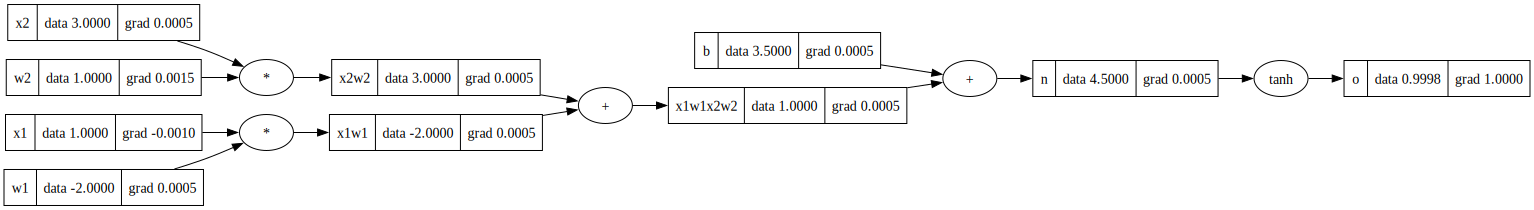

In [11]:
draw_dot(o)

# Second example , 2 inputs hidden layer

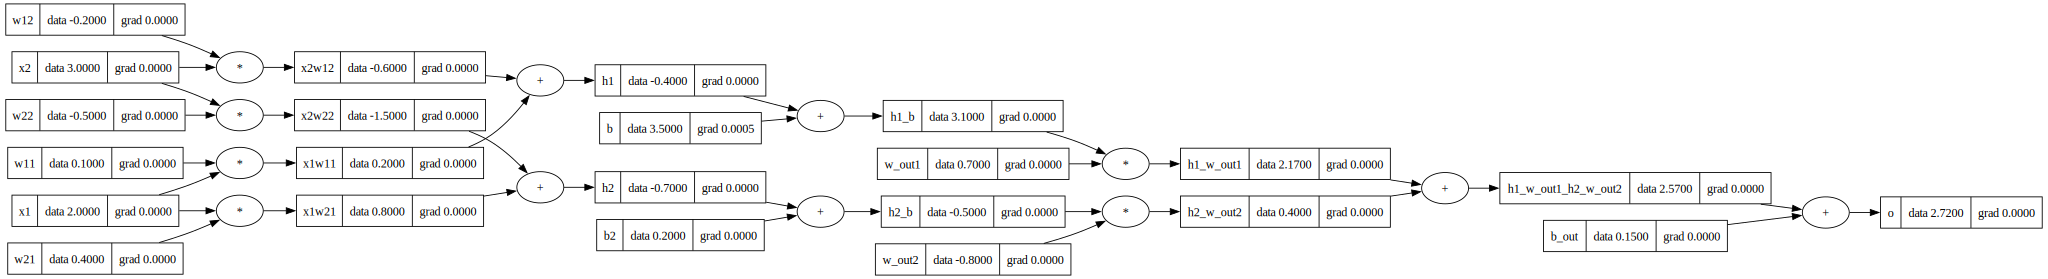

In [12]:
# Input variables
x1 = Value(2.0, label='x1')
x2 = Value(3.0, label='x2')

# Hidden layer weights
w11 = Value(0.1, label='w11')
w12 = Value(-0.2, label='w12')
w21 = Value(0.4, label='w21')
w22 = Value(-0.5, label='w22')

# Hidden layer biases
b1 = Value(-0.5, label='b1')
b2 = Value(0.2, label='b2')

# Hidden layer activations
x1w11 = x1 * w11 ; x1w11.label = 'x1w11'
x2w12 = x2 * w12 ; x2w12.label = 'x2w12'

x1w21 = x1 * w21 ; x1w21.label = 'x1w21'
x2w22 = x2 * w22 ; x2w22.label = 'x2w22'


x1w11x2w12 = x1w11 + x2w12
x1w11x2w12.label = 'x1w11x2w12'
h1 = x1w11x2w12 
h1.label = 'h1'

h1_b = h1 + b
h1_b.label = 'h1_b'

x1w21x2w22 = x1w21 + x2w22
x1w21x2w22.label = 'x1w21x2w22'
h2 = x1w21x2w22 
h2.label = 'h2'

h2_b = h2 + b2
h2_b.label = 'h2_b'

# Output layer weights
w_out1 = Value(0.7, label='w_out1')
w_out2 = Value(-0.8, label='w_out2')

# Output layer bias
b_out = Value(0.15, label='b_out')

# Output layer activation
h1_w_out1 = h1_b * w_out1
h1_w_out1.label = 'h1_w_out1'
h2_w_out2 = h2_b * w_out2
h2_w_out2.label = 'h2_w_out2'

h1_w_out1_h2_w_out2 = h1_w_out1 + h2_w_out2
h1_w_out1_h2_w_out2.label = 'h1_w_out1_h2_w_out2'
o = h1_w_out1_h2_w_out2 + b_out

o.label = 'o'
draw_dot(o)

In [13]:
o.backward()

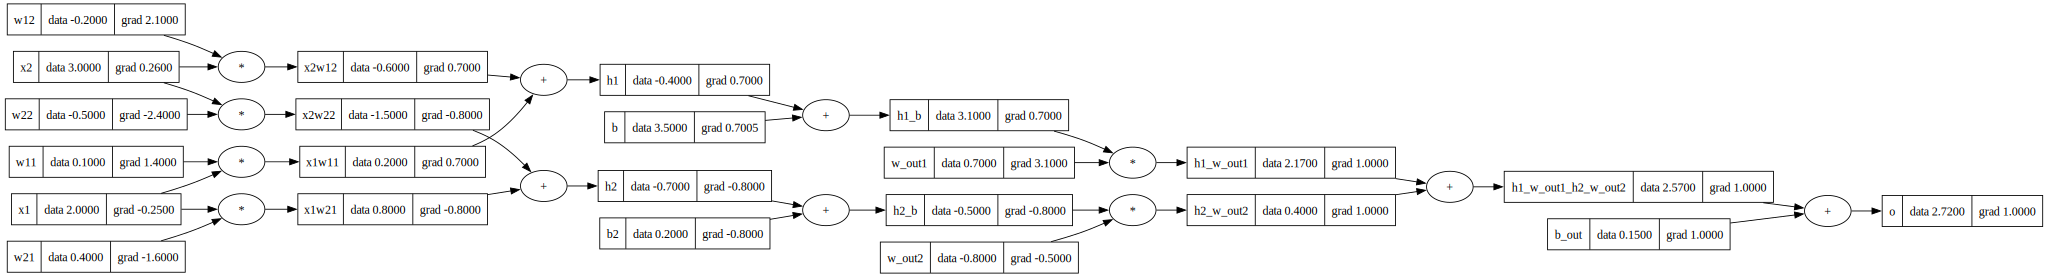

In [14]:
draw_dot(o)

In [15]:
#!pip install torch torchvision torchaudio

In [16]:
# verify the gradient using the torch library
# torch should give you the exact same gradient
import torch

x1 = torch.Tensor([1.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([3.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-2.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([3.5]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print("o.item = ", o.item())
o.backward()

print('--------')
print("x2.grad = ", x2.grad.item())
print("w2.grad = ", w2.grad.item())
print("x1.grad = ", x1.grad.item())
print("w1.grad = ", w1.grad.item())



o.item =  0.9997532108480275
--------
x2.grad =  0.000493517399059451
w2.grad =  0.001480552197178353
x1.grad =  -0.000987034798118902
w1.grad =  0.000493517399059451


In [17]:
# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function

# Define the softmax function
def softmax(logits):
  counts = [logit.exp() for logit in logits]      # Compute the exponential of each logit and store in counts
  denominator = sum(counts)     # Calculate the sum of all exponential values
  out = [c / denominator for c in counts]      # Compute softmax probabilities by dividing each exponential value by the denominator
  return out

# Define the negative log likelihood loss function
def neg_log_likelihood_loss(logits, label):
    # Apply softmax function to obtain probabilities
    probs = softmax(logits)
    # Retrieve the probability corresponding to the correct class (label)
    correct_prob = probs[label]
    # Compute the negative logarithm of the correct probability to get the loss
    loss = -correct_prob.log()
    return loss

# Example usage of softmax and negative log likelihood loss functions
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
# Assume label 3 (index 3) is the correct class
label = 3
# Compute the negative log likelihood loss
loss = neg_log_likelihood_loss(logits, label)
# Perform backward propagation to compute gradients
loss.backward()

# Expected gradients for each dimension
ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]

# Compare computed gradients with expected values and print results
for dim in range(4):
    # Check if computed gradient is close to expected value
    ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
    # Print the comparison result
    print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")


OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986


In [18]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# Example on NN

In [19]:
# Define the dimensions of the network
nin = 3  # Number of input neurons
hidden_neurons = [4]  # Number of neurons in the hidden layer(s)
nout = 1  # Number of output neurons

# Create the MLP
mlp = MLP(nin, hidden_neurons + [nout])

# Check the parameters of the MLP
print("Parameters of the MLP, Randomly intianlized:")
for param in mlp.parameters():
    print(param)

Parameters of the MLP, Randomly intianlized:
Value(data=0.7321309188269431)
Value(data=-0.6551436528452765)
Value(data=0.01585845609671699)
Value(data=-0.8988748373280557)
Value(data=0.8169072601653578)
Value(data=0.2738581439006098)
Value(data=-0.5189974875088745)
Value(data=0.08910646452920523)
Value(data=-0.07805834252351795)
Value(data=0.2249085807105622)
Value(data=0.33498964128795294)
Value(data=0.43330085948881103)
Value(data=0.2329902065424807)
Value(data=0.34247574096234)
Value(data=0.7113341214245068)
Value(data=0.748754804815738)
Value(data=0.1723861834613829)
Value(data=-0.8395981796456418)
Value(data=-0.0986404614243015)
Value(data=-0.8180883138340029)
Value(data=0.2339033699113564)


In [20]:
# Define training data Xtrain and Ytrain
Xtrain = Value([
    [0.1, 0.2, 0.3],   # Input for the first sample
    [0.4, 0.5, 0.6],   # Input for the second sample
    [0.6, 0.3, 0.2],   # Input for the 3th sample
    [0.8, 0.4, 0.1],   # Input for the 4th sample
])

Y= [ 0.7, 0.8, 0.5, 0.2]
Ytrain = [Value(i) for i in Y]


print("Xtrain:", Xtrain)
print("Ytrain:", Ytrain)

Xtrain: Value(data=[[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.6, 0.3, 0.2], [0.8, 0.4, 0.1]])
Ytrain: [Value(data=0.7), Value(data=0.8), Value(data=0.5), Value(data=0.2)]


In [21]:
# Makde the prediction based on dataset in Ypred
Ypred = [mlp(x) for x in Xtrain.data]
Ypred = [Ypred[i][0] for i in range(len(Ypred)) ]
print("Ypred:", Ypred)


Ypred: [Value(data=-0.5676761564216991), Value(data=-0.7074671094652427), Value(data=-0.7622923596525718), Value(data=-0.8094230936807693)]


In [22]:
# Initialize total loss to zero
loss = Value(0)  

# Iterate through each training data and calculate the output
for yt, yp in zip(Ytrain, Ypred):
    squared_diff = (yp - yt) ** 2  # Calculate squared difference
    loss += squared_diff  # Accumulate squared differences

# Print the total loss
print("Loss:", loss)


Loss: Value(data=6.491776906972898)


In [23]:
loss.backward()
for p in mlp.parameters():
  p.data += -0.01 * p.grad

Ypred = [mlp(x) for x in Xtrain.data]
Ypred = [Ypred[i][0] for i in range(len(Ypred)) ]

loss = sum((yp - yt)**2 for yt, yp in zip(Ytrain, Ypred))
# Print updated total loss
print("Loss:", loss)

Loss: Value(data=5.606786601159188)


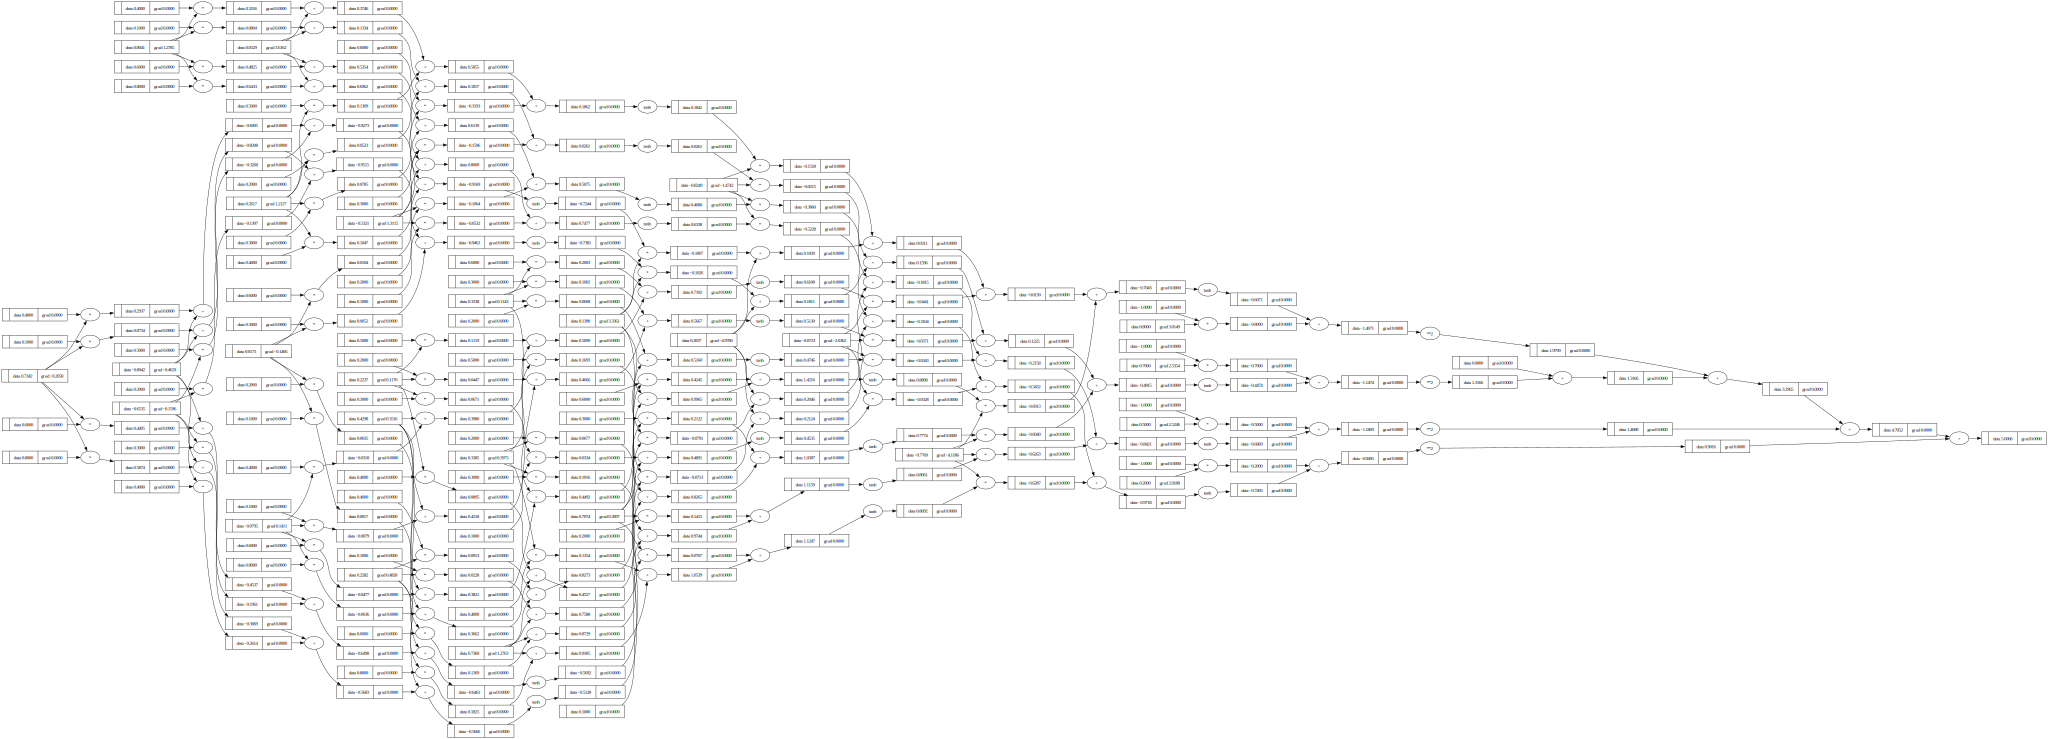

In [24]:
draw_dot(loss)

# Training in 500+ Epochs

In [27]:
for e in range(500):
    Ypred = [mlp(x) for x in Xtrain.data]
    Ypred = [Ypred[i][0] for i in range(len(Ypred)) ]

    loss = sum((yp - yt)**2 for yt, yp in zip(Ytrain, Ypred))

    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    for p in mlp.parameters():
        p.data += -0.05 * p.grad
    print(e, loss.data)

0 0.005130724355558583
1 0.0051239692916050395
2 0.0051172306256170325
3 0.005110508298370759
4 0.005103802250912412
5 0.005097112424556618
6 0.005090438760885094
7 0.005083781201744984
8 0.0050771396892475475
9 0.0050705141657667535
10 0.005063904573937727
11 0.00505731085665537
12 0.005050732957073015
13 0.005044170818600894
14 0.0050376243849048685
15 0.005031093599904872
16 0.005024578407773757
17 0.00501807875293573
18 0.005011594580065091
19 0.0050051258340847735
20 0.004998672460165189
21 0.004992234403722663
22 0.004985811610418234
23 0.004979404026156369
24 0.004973011597083527
25 0.004966634269586942
26 0.00496027199029331
27 0.004953924706067486
28 0.004947592364011199
29 0.004941274911461763
30 0.004934972295990949
31 0.00492868446540347
32 0.004922411367735997
33 0.004916152951255788
34 0.004909909164459363
35 0.004903679956071487
36 0.004897465275043834
37 0.004891265070553734
38 0.004885079292003141
39 0.004878907889017144
40 0.004872750811443102
41 0.004866608009349273


In [26]:
# Makde the output after training
Yout = [mlp(x) for x in Xtrain.data]
Yout = [Yout[i][0] for i in range(len(Yout))]

# Print the predictions and true values in a more readable format
print("Predicted   True")
for pred, true in zip(Yout, Ytrain):
    print(f'{pred.data:.4f}       {true.data:.4f}')


Predicted   True
0.7477       0.7000
0.7742       0.8000
0.4598       0.5000
0.2240       0.2000


In [ ]:
# Backward
loss.backward()

# Updating parameters
with torch.no_grad():
    for param in n.parameters():
        param.grad *= 0  # Clear gradients manually

# Compute new predictions
ypred = [n(x) for x in xs.data]
ypred = [ypred[i][0] for i in range(len(ypred))]

# Compute new loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

# Print the new loss
print(loss)

In [ ]:
draw_dot(loss)

# Building Neural Network by Torch

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Value class
class Value:
    def __init__(self, data):
        self.data = data

# Define the MLP class
class MLP(nn.Module):
    def __init__(self, nin, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        prev_neurons = nin
        for neurons in hidden_layers:
            layers.append(nn.Linear(prev_neurons, neurons))
            layers.append(nn.ReLU())
            prev_neurons = neurons
        layers.append(nn.Linear(prev_neurons, 1))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define training data
Xtrain = torch.tensor([
    [0.1, 0.2, 0.3],   # Input for the first sample
    [0.4, 0.5, 0.6],   # Input for the second sample
    [0.6, 0.3, 0.2],   # Input for the third sample
    [0.8, 0.4, 0.1],   # Input for the fourth sample
], dtype=torch.float32)

Ytrain = [Value(i) for i in [0.7, 0.8, 0.5, 0.2]]  # Wrap the true values in the Value class

print("Xtrain:", Xtrain)
print("Ytrain:", [y.data for y in Ytrain])  # Print the values inside the Value class

# Define the dimensions of the network
nin = 3  # Number of input neurons
hidden_neurons = [4]  # Number of neurons in the hidden layer(s)

# Create the MLP
mlp = MLP(nin, hidden_neurons)

# Check the parameters of the MLP
print("Parameters of the MLP, randomly initialized:")
for param in mlp.parameters():
    print(param)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.05)

# Training loop
for e in range(5000):
    optimizer.zero_grad()
    Ypred = mlp(Xtrain)
    loss = criterion(Ypred, torch.tensor([[y.data for y in Ytrain]]).t())  # Convert Ytrain to tensor and transpose
    loss.backward()
    optimizer.step()
    if e % 500 == 0:  # Print loss every 500 epochs
        print(f'Epoch {e}/{500}, Loss: {loss.item()}')

# Test the model with the training data
with torch.no_grad():  # Disable gradient computation for testing
    Ypred = mlp(Xtrain)

print("Final Training Loss:", loss.item())
print("Predicted values vs True values")
for pred, true in zip(Ypred.squeeze().tolist(), [y.data for y in Ytrain]):
    print(f'Predicted: {pred:.4f}, True: {true:.4f}')



Xtrain: tensor([[0.1000, 0.2000, 0.3000],
        [0.4000, 0.5000, 0.6000],
        [0.6000, 0.3000, 0.2000],
        [0.8000, 0.4000, 0.1000]])
Ytrain: [0.7, 0.8, 0.5, 0.2]
Parameters of the MLP, randomly initialized:
Parameter containing:
tensor([[-0.0172,  0.5679,  0.2447],
        [-0.5611, -0.2658,  0.3881],
        [ 0.0619,  0.3069,  0.3843],
        [ 0.5135, -0.0260, -0.1422]], requires_grad=True)
Parameter containing:
tensor([ 0.2412,  0.0768, -0.1362,  0.4954], requires_grad=True)
Parameter containing:
tensor([[0.2400, 0.3179, 0.0806, 0.0650]], requires_grad=True)
Parameter containing:
tensor([-0.3704], requires_grad=True)
Epoch 0/500, Loss: 0.5936272740364075
Epoch 500/500, Loss: 0.003026007441803813
Epoch 1000/500, Loss: 0.002800961723551154
Epoch 1500/500, Loss: 0.002677066484466195
Epoch 2000/500, Loss: 0.002561424393206835
Epoch 2500/500, Loss: 0.002448546700179577
Epoch 3000/500, Loss: 0.0023376685567200184
Epoch 3500/500, Loss: 0.00222837389446795
Epoch 4000/500, Loss